In [74]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from collections import namedtuple
import functools

import tensorflow as tf

slim = tf.contrib.slim
Conv = namedtuple('Conv', ['kernel', 'stride', 'depth'])
DepthSepConv = namedtuple('DepthSepConv', ['kernel', 'stride', 'depth'])

# _CONV_DEFS specifies the MobileNet body
_CONV_DEFS = [
    Conv(kernel=[3, 3], stride=2, depth=32),
    DepthSepConv(kernel=[3, 3], stride=1, depth=64),
    DepthSepConv(kernel=[3, 3], stride=2, depth=128),
    DepthSepConv(kernel=[3, 3], stride=1, depth=128),
    DepthSepConv(kernel=[3, 3], stride=2, depth=256),
    DepthSepConv(kernel=[3, 3], stride=1, depth=256),
    DepthSepConv(kernel=[3, 3], stride=2, depth=512),
    DepthSepConv(kernel=[3, 3], stride=1, depth=512),
    DepthSepConv(kernel=[3, 3], stride=1, depth=512),
    DepthSepConv(kernel=[3, 3], stride=1, depth=512),
    DepthSepConv(kernel=[3, 3], stride=1, depth=512),
    DepthSepConv(kernel=[3, 3], stride=1, depth=512),
    DepthSepConv(kernel=[3, 3], stride=2, depth=1024),
    DepthSepConv(kernel=[3, 3], stride=1, depth=1024)
]

def _reduced_kernel_size_for_small_input(input_tensor, kernel_size):
  """Define kernel size which is automatically reduced for small input.
  If the shape of the input images is unknown at graph construction time this
  function assumes that the input images are large enough.
  Args:
    input_tensor: input tensor of size [batch_size, height, width, channels].
    kernel_size: desired kernel size of length 2: [kernel_height, kernel_width]
  Returns:
    a tensor with the kernel size.
  """
  shape = input_tensor.get_shape().as_list()
  if shape[1] is None or shape[2] is None:
    kernel_size_out = kernel_size
  else:
    kernel_size_out = [min(shape[1], kernel_size[0]),
                       min(shape[2], kernel_size[1])]
  return kernel_size_out

def mobilenet_v1_base(inputs,
                      final_endpoint='Conv2d_13_pointwise',
                      min_depth=8,
                      depth_multiplier=1.0,
                      conv_defs=None,
                      output_stride=None,
                      scope=None):
  """Mobilenet v1.
  Constructs a Mobilenet v1 network from inputs to the given final endpoint.
  Args:
    inputs: a tensor of shape [batch_size, height, width, channels].
    final_endpoint: specifies the endpoint to construct the network up to. It
      can be one of ['Conv2d_0', 'Conv2d_1_pointwise', 'Conv2d_2_pointwise',
      'Conv2d_3_pointwise', 'Conv2d_4_pointwise', 'Conv2d_5_pointwise',
      'Conv2d_6_pointwise', 'Conv2d_7_pointwise', 'Conv2d_8_pointwise',
      'Conv2d_9_pointwise', 'Conv2d_10_pointwise', 'Conv2d_11_pointwise',
      'Conv2d_12_pointwise', 'Conv2d_13_pointwise'].
    min_depth: Minimum depth value (number of channels) for all convolution ops.
      Enforced when depth_multiplier < 1, and not an active constraint when
      depth_multiplier >= 1.
    depth_multiplier: Float multiplier for the depth (number of channels)
      for all convolution ops. The value must be greater than zero. Typical
      usage will be to set this value in (0, 1) to reduce the number of
      parameters or computation cost of the model.
    conv_defs: A list of ConvDef namedtuples specifying the net architecture.
    output_stride: An integer that specifies the requested ratio of input to
      output spatial resolution. If not None, then we invoke atrous convolution
      if necessary to prevent the network from reducing the spatial resolution
      of the activation maps. Allowed values are 8 (accurate fully convolutional
      mode), 16 (fast fully convolutional mode), 32 (classification mode).
    scope: Optional variable_scope.
  Returns:
    tensor_out: output tensor corresponding to the final_endpoint.
    end_points: a set of activations for external use, for example summaries or
                losses.
  Raises:
    ValueError: if final_endpoint is not set to one of the predefined values,
                or depth_multiplier <= 0, or the target output_stride is not
                allowed.
  """
  depth = lambda d: max(int(d * depth_multiplier), min_depth)
  end_points = {}

  # Used to find thinned depths for each layer.
  if depth_multiplier <= 0:
    raise ValueError('depth_multiplier is not greater than zero.')

  if conv_defs is None:
    conv_defs = _CONV_DEFS

  if output_stride is not None and output_stride not in [8, 16, 32]:
    raise ValueError('Only allowed output_stride values are 8, 16, 32.')

  with tf.variable_scope(scope, 'MobilenetV1', [inputs]):
    with slim.arg_scope([slim.conv2d, slim.separable_conv2d], padding='SAME'):
      # The current_stride variable keeps track of the output stride of the
      # activations, i.e., the running product of convolution strides up to the
      # current network layer. This allows us to invoke atrous convolution
      # whenever applying the next convolution would result in the activations
      # having output stride larger than the target output_stride.
      current_stride = 1

      # The atrous convolution rate parameter.
      rate = 1

      net = inputs
      for i, conv_def in enumerate(conv_defs):
        end_point_base = 'Conv2d_%d' % i

        if output_stride is not None and current_stride == output_stride:
          # If we have reached the target output_stride, then we need to employ
          # atrous convolution with stride=1 and multiply the atrous rate by the
          # current unit's stride for use in subsequent layers.
          layer_stride = 1
          layer_rate = rate
          rate *= conv_def.stride
        else:
          layer_stride = conv_def.stride
          layer_rate = 1
          current_stride *= conv_def.stride

        if isinstance(conv_def, Conv):
          end_point = end_point_base
          net = slim.conv2d(net, depth(conv_def.depth), conv_def.kernel,
                            stride=conv_def.stride,
                            normalizer_fn=slim.batch_norm,
                            scope=end_point)
          end_points[end_point] = net
          if end_point == final_endpoint:
            return net, end_points

        elif isinstance(conv_def, DepthSepConv):
          end_point = end_point_base + '_depthwise'

          # By passing filters=None
          # separable_conv2d produces only a depthwise convolution layer
          net = slim.separable_conv2d(net, None, conv_def.kernel,
                                      depth_multiplier=1,
                                      stride=layer_stride,
                                      rate=layer_rate,
                                      normalizer_fn=slim.batch_norm,
                                      scope=end_point)

          end_points[end_point] = net
          if end_point == final_endpoint:
            return net, end_points

          end_point = end_point_base + '_pointwise'

          net = slim.conv2d(net, depth(conv_def.depth), [1, 1],
                            stride=1,
                            normalizer_fn=slim.batch_norm,
                            scope=end_point)

          end_points[end_point] = net
          if end_point == final_endpoint:
            return net, end_points
        else:
          raise ValueError('Unknown convolution type %s for layer %d'
                           % (conv_def.ltype, i))
  raise ValueError('Unknown final endpoint %s' % final_endpoint)


def mobilenet_v1(inputs,
                 num_classes=1000,
                 dropout_keep_prob=0.999,
                 is_training=True,
                 min_depth=8,
                 depth_multiplier=1.0,
                 conv_defs=None,
                 prediction_fn=tf.contrib.layers.softmax,
                 spatial_squeeze=True,
                 reuse=None,
                 scope='MobilenetV1'):
  """Mobilenet v1 model for classification.
  Args:
    inputs: a tensor of shape [batch_size, height, width, channels].
    num_classes: number of predicted classes.
    dropout_keep_prob: the percentage of activation values that are retained.
    is_training: whether is training or not.
    min_depth: Minimum depth value (number of channels) for all convolution ops.
      Enforced when depth_multiplier < 1, and not an active constraint when
      depth_multiplier >= 1.
    depth_multiplier: Float multiplier for the depth (number of channels)
      for all convolution ops. The value must be greater than zero. Typical
      usage will be to set this value in (0, 1) to reduce the number of
      parameters or computation cost of the model.
    conv_defs: A list of ConvDef namedtuples specifying the net architecture.
    prediction_fn: a function to get predictions out of logits.
    spatial_squeeze: if True, logits is of shape is [B, C], if false logits is
        of shape [B, 1, 1, C], where B is batch_size and C is number of classes.
    reuse: whether or not the network and its variables should be reused. To be
      able to reuse 'scope' must be given.
    scope: Optional variable_scope.
  Returns:
    logits: the pre-softmax activations, a tensor of size
      [batch_size, num_classes]
    end_points: a dictionary from components of the network to the corresponding
      activation.
  Raises:
    ValueError: Input rank is invalid.
  """
  input_shape = inputs.get_shape().as_list()
  if len(input_shape) != 4:
    raise ValueError('Invalid input tensor rank, expected 4, was: %d' %
                     len(input_shape))

  with tf.variable_scope(scope, 'MobilenetV1', [inputs, num_classes],
                         reuse=reuse) as scope:
    with slim.arg_scope([slim.batch_norm, slim.dropout],
                        is_training=is_training):
      net, end_points = mobilenet_v1_base(inputs, scope=scope,
                                          min_depth=min_depth,
                                          depth_multiplier=depth_multiplier,
                                          conv_defs=conv_defs)
      with tf.variable_scope('Logits'):
        kernel_size = _reduced_kernel_size_for_small_input(net, [7, 7])
        net = slim.avg_pool2d(net, kernel_size, padding='VALID',
                              scope='AvgPool_1a')
        end_points['AvgPool_1a'] = net
        # 1 x 1 x 1024
        net = slim.dropout(net, keep_prob=dropout_keep_prob, scope='Dropout_1b')
        logits = slim.conv2d(net, num_classes, [1, 1], activation_fn=None,
                             normalizer_fn=None, scope='Conv2d_1c_1x1')
        if spatial_squeeze:
          logits = tf.squeeze(logits, [1, 2], name='SpatialSqueeze')
      end_points['Logits'] = logits
      if prediction_fn:
        end_points['Predictions'] = prediction_fn(logits, scope='Predictions')
  return logits, end_points

In [76]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [77]:
def get_accuracy(labels, y):    
    correct_prediction = tf.equal(tf.argmax(y,1), labels)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return accuracy

In [78]:
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)

In [79]:
epochs = 10
batch_size = 64
print_every = 100
plot_loss = True

Iteration 0: training loss = 2.64, train accuracy of 0.078
Iteration 100: training loss = 2.37, train accuracy of 0.11
Iteration 200: training loss = 2.11, train accuracy of 0.17
Iteration 300: training loss = 2.22, train accuracy of 0.16
Iteration 400: training loss = 2.06, train accuracy of 0.17
Iteration 500: training loss = 1.85, train accuracy of 0.34
Iteration 600: training loss = 1.97, train accuracy of 0.2
Iteration 700: training loss = 1.93, train accuracy of 0.27
Epoch 1, train loss = 159, train accuracy of 0.199, val loss = 1.88, val acc = 0.232



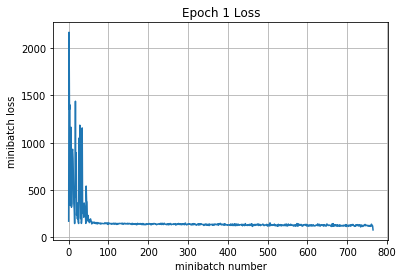

Iteration 800: training loss = 1.94, train accuracy of 0.31
Iteration 900: training loss = 1.82, train accuracy of 0.22
Iteration 1000: training loss = 1.88, train accuracy of 0.27
Iteration 1100: training loss = 1.92, train accuracy of 0.16
Iteration 1200: training loss = 1.78, train accuracy of 0.31
Iteration 1300: training loss = 1.73, train accuracy of 0.3
Iteration 1400: training loss = 1.84, train accuracy of 0.2
Iteration 1500: training loss = 1.55, train accuracy of 0.27
Epoch 2, train loss = 118, train accuracy of 0.27, val loss = 1.74, val acc = 0.306



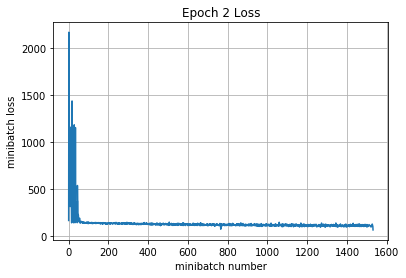

Iteration 1600: training loss = 1.56, train accuracy of 0.36
Iteration 1700: training loss = 1.8, train accuracy of 0.31
Iteration 1800: training loss = 1.84, train accuracy of 0.33
Iteration 1900: training loss = 1.62, train accuracy of 0.44
Iteration 2000: training loss = 1.81, train accuracy of 0.34
Iteration 2100: training loss = 1.77, train accuracy of 0.39
Iteration 2200: training loss = 1.69, train accuracy of 0.3
Epoch 3, train loss = 109, train accuracy of 0.348, val loss = 1.61, val acc = 0.404



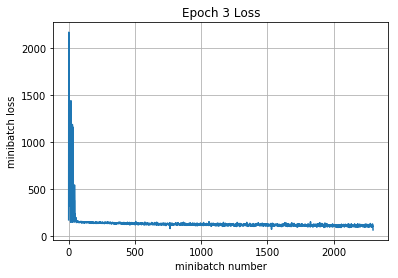

Iteration 2300: training loss = 1.79, train accuracy of 0.38
Iteration 2400: training loss = 1.63, train accuracy of 0.34
Iteration 2500: training loss = 1.88, train accuracy of 0.25
Iteration 2600: training loss = 1.7, train accuracy of 0.31
Iteration 2700: training loss = 2, train accuracy of 0.31
Iteration 2800: training loss = 1.46, train accuracy of 0.5
Iteration 2900: training loss = 1.63, train accuracy of 0.47
Iteration 3000: training loss = 1.58, train accuracy of 0.38
Epoch 4, train loss = 101, train accuracy of 0.413, val loss = 1.48, val acc = 0.456



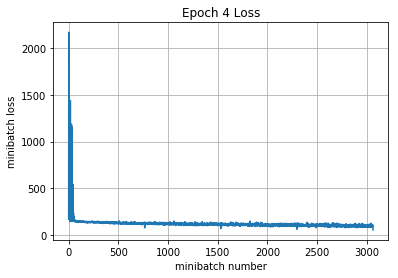

Iteration 3100: training loss = 1.41, train accuracy of 0.41
Iteration 3200: training loss = 1.37, train accuracy of 0.45
Iteration 3300: training loss = 1.38, train accuracy of 0.47
Iteration 3400: training loss = 1.32, train accuracy of 0.55
Iteration 3500: training loss = 1.37, train accuracy of 0.48
Iteration 3600: training loss = 1.22, train accuracy of 0.58
Iteration 3700: training loss = 1.5, train accuracy of 0.47
Iteration 3800: training loss = 1.63, train accuracy of 0.31
Epoch 5, train loss = 91.7, train accuracy of 0.473, val loss = 1.37, val acc = 0.487



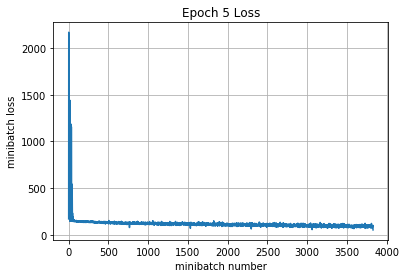

Iteration 3900: training loss = 1.12, train accuracy of 0.59
Iteration 4000: training loss = 1.49, train accuracy of 0.44
Iteration 4100: training loss = 1.15, train accuracy of 0.5
Iteration 4200: training loss = 1.23, train accuracy of 0.56
Iteration 4300: training loss = 1.26, train accuracy of 0.56
Iteration 4400: training loss = 1.18, train accuracy of 0.58
Iteration 4500: training loss = 1.29, train accuracy of 0.5
Epoch 6, train loss = 84.7, train accuracy of 0.517, val loss = 1.25, val acc = 0.544



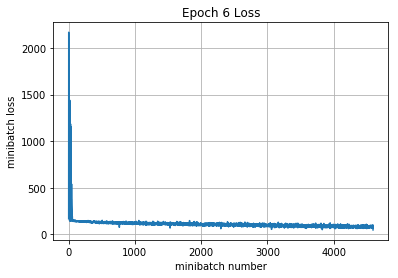

Iteration 4600: training loss = 1.23, train accuracy of 0.61
Iteration 4700: training loss = 1.37, train accuracy of 0.55
Iteration 4800: training loss = 1.43, train accuracy of 0.47
Iteration 4900: training loss = 1.43, train accuracy of 0.5
Iteration 5000: training loss = 1.06, train accuracy of 0.69
Iteration 5100: training loss = 1.19, train accuracy of 0.52
Iteration 5200: training loss = 0.958, train accuracy of 0.64
Iteration 5300: training loss = 1.3, train accuracy of 0.5
Epoch 7, train loss = 79, train accuracy of 0.561, val loss = 1.2, val acc = 0.571



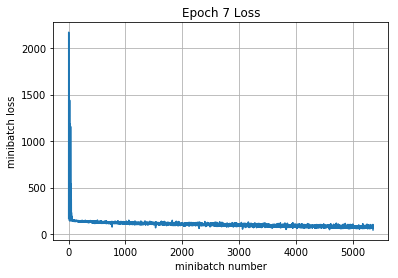

Iteration 5400: training loss = 1.29, train accuracy of 0.48
Iteration 5500: training loss = 0.949, train accuracy of 0.61
Iteration 5600: training loss = 1.24, train accuracy of 0.47
Iteration 5700: training loss = 1.26, train accuracy of 0.52
Iteration 5800: training loss = 1.38, train accuracy of 0.48
Iteration 5900: training loss = 1.05, train accuracy of 0.62
Iteration 6000: training loss = 1.08, train accuracy of 0.59
Iteration 6100: training loss = 1.02, train accuracy of 0.61
Epoch 8, train loss = 74.3, train accuracy of 0.589, val loss = 1.13, val acc = 0.576



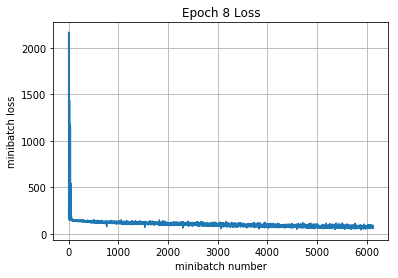

Iteration 6200: training loss = 1.67, train accuracy of 0.5
Iteration 6300: training loss = 1.15, train accuracy of 0.61
Iteration 6400: training loss = 1.02, train accuracy of 0.61
Iteration 6500: training loss = 0.907, train accuracy of 0.73
Iteration 6600: training loss = 1.17, train accuracy of 0.58
Iteration 6700: training loss = 1.02, train accuracy of 0.66
Iteration 6800: training loss = 0.812, train accuracy of 0.7
Epoch 9, train loss = 71.3, train accuracy of 0.61, val loss = 1.17, val acc = 0.585



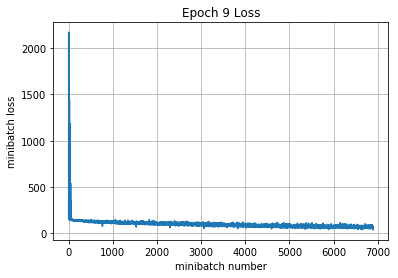

Iteration 6900: training loss = 0.958, train accuracy of 0.64
Iteration 7000: training loss = 1.05, train accuracy of 0.62
Iteration 7100: training loss = 1.07, train accuracy of 0.62
Iteration 7200: training loss = 1.03, train accuracy of 0.59
Iteration 7300: training loss = 1.06, train accuracy of 0.69
Iteration 7400: training loss = 1.39, train accuracy of 0.61
Iteration 7500: training loss = 1.06, train accuracy of 0.66
Iteration 7600: training loss = 1.36, train accuracy of 0.48
Epoch 10, train loss = 69.7, train accuracy of 0.617, val loss = 1.13, val acc = 0.58



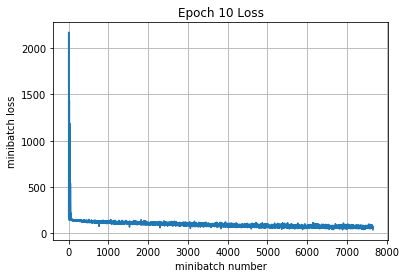

In [80]:
tf.reset_default_graph()    

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

#inputs,num_classes=1000,is_training=True,width_multiplier=1,scope='MobileNet'
logits, _ = mobilenet_v1(inputs = X, num_classes=10, is_training=is_training)
accuracy_op = get_accuracy(y, logits)
loss_op = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y, 10), logits=logits)
)


optimizer = tf.train.AdamOptimizer(learning_rate = 1e-1)
train_op = optimizer.minimize(loss = loss_op) 

train_indices = np.arange(X_train.shape[0])
np.random.shuffle(train_indices)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(config=config) as session:
    tf.global_variables_initializer().run()
    # counter 
    iter_cnt = 0
    all_losses = []
    train_acc = []
    val_acc = []
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = []
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(X_train.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%X_train.shape[0]
            idx = train_indices[start_idx:start_idx+batch_size]

            # create a feed dictionary for this batch
            feed_dict = {X: X_train[idx,:],
                         y: y_train[idx],
                        is_training : True}
            # get batch size
            actual_batch_size = y_train[idx].shape[0]

            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, acc, _ = session.run([loss_op, accuracy_op, train_op], feed_dict=feed_dict)
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct.append(acc)

            # print every now and then
            if not iter_cnt % print_every:
                print("Iteration {0}: training loss = {1:.3g}, train accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,acc))
            iter_cnt += 1

        epoch_train_acc = np.sum(correct)/int(math.ceil(X_train.shape[0]/batch_size))
        epoch_train_loss = np.sum(losses)/int(math.ceil(X_train.shape[0]/batch_size))

        feed_dict = {X: X_val,
                     y: y_val,
                    is_training: True}

        epoch_val_loss, epoch_val_acc = session.run([loss_op, accuracy_op], feed_dict)

        print("Epoch {4}, train loss = {0:.3g}, train accuracy of {1:.3g}, val loss = {2:.3g}, val acc = {3:.3g}" \
              .format(epoch_train_loss, epoch_train_acc, epoch_val_loss, epoch_val_acc, e+1))
        print()
        
        all_losses += losses
        train_acc.append(epoch_train_acc)
        val_acc.append(epoch_val_acc)
        
        if plot_loss:
            plt.plot(all_losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()